In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.python.ops.losses.losses_impl import log_loss

In [3]:
df = pd.read_csv('data/WA_Fn-UseC_-HR-Employee-Attrition.csv')

filtered_df=df[[
    'Age', 'Attrition', 'EnvironmentSatisfaction', 'JobInvolvement',
    'JobLevel', 'JobSatisfaction', 'MonthlyIncome', 'OverTime',
    'StockOptionLevel', 'TotalWorkingYears', 'YearsAtCompany',
    'YearsInCurrentRole', 'YearsWithCurrManager'
]]
filtered_df

,Age,Attrition,EnvironmentSatisfaction,JobInvolvement,JobLevel,JobSatisfaction,MonthlyIncome,OverTime,StockOptionLevel,TotalWorkingYears,YearsAtCompany,YearsInCurrentRole,YearsWithCurrManager
0,41,Yes,2,3,2,4,5993,Yes,0,8,6,4,5
1,49,No,3,2,2,2,5130,No,1,10,10,7,7
2,37,Yes,4,2,1,3,2090,Yes,0,7,0,0,0
3,33,No,4,3,1,3,2909,Yes,0,8,8,7,0
4,27,No,1,3,1,2,3468,No,1,6,2,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1465,36,No,3,4,2,4,2571,No,1,17,5,2,3
1466,39,No,4,2,3,1,9991,No,1,9,7,7,7
1467,27,No,2,4,2,2,6142,Yes,1,6,6,2,3
1468,49,No,4,2,2,2,5390,No,0,17,9,6,8


In [13]:
from sklearn.preprocessing import OneHotEncoder,RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score,precision_score,accuracy_score,f1_score,log_loss

categorical_df = filtered_df[['Attrition','OverTime']]
numerical_df = filtered_df[[
    'Age', 'EnvironmentSatisfaction', 'JobInvolvement',
    'JobLevel', 'JobSatisfaction', 'MonthlyIncome',
    'StockOptionLevel', 'TotalWorkingYears', 'YearsAtCompany',
    'YearsInCurrentRole', 'YearsWithCurrManager'
]]

encoder = OneHotEncoder(drop='first', sparse_output=False)

encoded_df = encoder.fit_transform(categorical_df)
encoded_cols = ['Attrition', 'OverTime']

# 인코딩 후 합침
X_encoded_df = pd.DataFrame(encoded_df, columns=encoded_cols, index=filtered_df.index).astype(int)
df = pd.concat([numerical_df, X_encoded_df], axis=1)

df


,Age,EnvironmentSatisfaction,JobInvolvement,JobLevel,JobSatisfaction,MonthlyIncome,StockOptionLevel,TotalWorkingYears,YearsAtCompany,YearsInCurrentRole,YearsWithCurrManager,Attrition,OverTime
0,41,2,3,2,4,5993,0,8,6,4,5,1,1
1,49,3,2,2,2,5130,1,10,10,7,7,0,0
2,37,4,2,1,3,2090,0,7,0,0,0,1,1
3,33,4,3,1,3,2909,0,8,8,7,0,0,1
4,27,1,3,1,2,3468,1,6,2,2,2,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1465,36,3,4,2,4,2571,1,17,5,2,3,0,0
1466,39,4,2,3,1,9991,1,9,7,7,7,0,0
1467,27,2,4,2,2,6142,1,6,6,2,3,0,1
1468,49,4,2,2,2,5390,0,17,9,6,8,0,0


In [14]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from xgboost import XGBClassifier

In [6]:
# 데이터 준비
X = df.drop(columns=['Attrition'])
y = df['Attrition']

In [20]:
import warnings

# use_label_encoder와 feature names warning 제거
warnings.filterwarnings("ignore", message=".*use_label_encoder.*")
warnings.filterwarnings("ignore", message=".*valid feature names.*")

def select_best_estimator(X_train, y_train, X_test, y_test):
    # 여러 모델과 해당 모델에 대한 하이퍼 파라미터 후보를 딕셔너리 형태로 정의
    # key: 모델 이름, value: (모델 객체, 하이퍼 파라미터 딕셔너리)
    models = {
        'RandomForest': (
            RandomForestClassifier(),
            {
                'n_estimators': [50, 100, 200],         # 트리 개수
                'max_depth': [None,5, 10, 15],          # 트리 최대 깊이
                'min_samples_split': [2, 5, 10],        # 내부 노드를 분할하기 위한 최소 샘플 수
                'min_samples_leaf': [1, 2, 4]           # 리프 노드에 있어야 하는 최소 샘플 수
            }
        ),
        'XGBoost': (
            XGBClassifier(eval_metric='logloss'),
            {
                'n_estimators': [50, 100, 200],         # 트리 개수
                'max_depth': [5, 7, 9],                 # 트리 최대 깊이
                'learning_rate': [0.01, 0.05, 0.1],     # 학습률
                'subsample': [0.8, 1.0],                # 샘플링 비율
                'colsample_bytree': [0.8, 1.0]          # 특성 샘플링 비율
            }
        ),
        'SVC': (
            SVC(probability=True),
            {
                'C': [0.1, 1, 10],                      # 정규화 강도
                'kernel': ['rbf'],                      # 커널 종류
                'gamma': ['scale', 'auto'],             # 감마 파라미터
                'class_weight': [None, 'balanced'],     # 클래스 불균형 조정
                'shrinking': [True, False]
            }
        ),
        'MLP': (
            MLPClassifier(max_iter=5000),
            {
                'hidden_layer_sizes': [(100,), (50, 50), (100, 50)], # 은닉층 구조
                'activation': ['relu', 'tanh'],                      # 활성화 함수
                'alpha': [0.001, 0.01],                              # L2 규제 계수
                'solver': ['adam']                                   # 최적화 알고리즘
            }
        ),
    }

    # StratifiedKFold를 사용해 데이터셋을 계층적으로 나누어 교차 검증
    skf = StratifiedKFold(n_splits=5, shuffle=True)

    # 각 모델의 결과를 저장할 리스트
    results = []
    loss_res = []

    # models.items()는 딕셔너리의 (key, value) 쌍을 반환
    # name은 모델 이름(문자열), (model, params)는 모델 객체와 파라미터 딕셔너리를 의미
    for name, (model, params) in models.items():
        # GridSearchCV로 하이퍼 파라미터 탐색(f1-score를 기준)
        grid = GridSearchCV(model, params, scoring='f1', cv=skf, n_jobs=-1)
        grid.fit(X_train, y_train)  # 학습 데이터로 그리드 탐색 수행

        # 최적 모델로 테스트 데이터 예측
        y_pred = grid.predict(X_test)
        y_pred_proba = grid.predict_proba(X_test) # 손실 구함

        # 모델 평가 지표 계산
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        loss = log_loss(y_test,y_pred_proba)

        # 각 모델의 평가 결과 출력
        print(f"[{name}]")
        print(f"  최적 파라미터 : {grid.best_params_ if grid.best_params_ else 'Default'}")
        print(f"  정확도  : {accuracy:.4f}")
        print(f"  정밀도  : {precision:.4f}")
        print(f"  재현율  : {recall:.4f}")
        print(f"  F1 Score: {f1:.4f}")
        print("-" * 50)

        # 결과 리스트에 (모델명, 최적 모델, 최적 파라미터, 정밀도, 재현율, f1) 저장
        results.append((name, grid.best_estimator_, grid.best_params_, precision, recall, f1, accuracy))
        loss_res.append((name,loss))

    # Recall을 점수를 우선으로, 동일하면 F1_score과 Precision을 기준으로 최고 모델 선택
    best_model = max(results, key=lambda x: (x[5], x[4], x[3],x[6]))  # x[5]=f1_score, x[3]=정밀도, x[4]=재현율
    best_model_name, best_model_instance, best_params, precision, recall, f1, accuracy = best_model
    # 순서대로 모델 이름, 모델 객체, 최적의 파라미터, 정밀도, 재현율, f1, 정확도

    # 최적 모델 평가 결과 출력
    print("\n" + "-" * 27)
    print("모델 평가 결과")
    print("-" * 27)
    print(f"최적의 모델  : {best_model_instance.__class__.__name__}")
    print(f"최적의 파라미터  : {best_params}")
    print(f"정확도  : {accuracy:.4f}")
    print(f"정밀도  : {precision:.4f}")
    print(f"재현율  : {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print("-" * 27)

    # 최적 모델 이름, 모델 객체, 하이퍼 파라미터 반환, 손실값
    return best_model_name, best_model_instance, best_params, loss_res


In [21]:
from collections import defaultdict

def record_model(n):
    loss_history = defaultdict(list)
    for i in range(n):
        # SMOTE
        smote = SMOTE()
        X_resampled, y_resampled = smote.fit_resample(X, y)

        # 스케일링
        scaler = RobustScaler()
        X_scaled = scaler.fit_transform(X_resampled)

        X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_resampled, test_size=0.2, stratify=y_resampled)

        # 최적의 모델 선택 및 학습
        best_model_name, _, _, loss = select_best_estimator(X_train, y_train, X_test, y_test)
        loss_history[best_model_name].append(loss)
    print('손실 함수 기록 :',loss_history)

    return loss_history

loss_history = record_model(10)

[RandomForest]
  최적 파라미터 : {'max_depth': 15, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
  정확도  : 0.8603
  정밀도  : 0.8618
  재현율  : 0.8583
  F1 Score: 0.8600
--------------------------------------------------
[XGBoost]
  최적 파라미터 : {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200, 'subsample': 0.8}
  정확도  : 0.8846
  정밀도  : 0.8992
  재현율  : 0.8664
  F1 Score: 0.8825
--------------------------------------------------
[SVC]
  최적 파라미터 : {'C': 10, 'class_weight': None, 'gamma': 'scale', 'kernel': 'rbf', 'shrinking': True}
  정확도  : 0.8340
  정밀도  : 0.8452
  재현율  : 0.8178
  F1 Score: 0.8313
--------------------------------------------------
[MLP]
  최적 파라미터 : {'activation': 'relu', 'alpha': 0.01, 'hidden_layer_sizes': (50, 50), 'solver': 'adam'}
  정확도  : 0.8320
  정밀도  : 0.8154
  재현율  : 0.8583
  F1 Score: 0.8363
--------------------------------------------------

---------------------------
모델 평가 결과
---------------------------
최적의 모델  : XGBC

TypeError: unhashable type: 'numpy.ndarray'

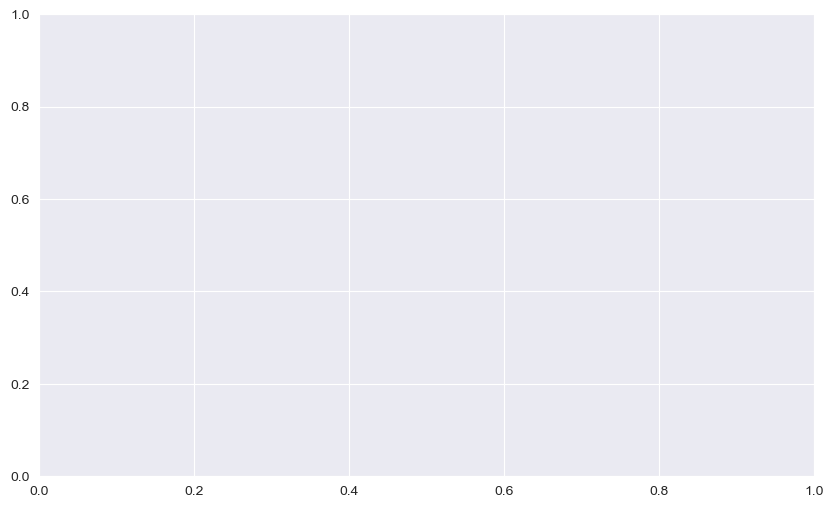

In [22]:
plt.figure(figsize=(10, 6))
n = len(next(iter(loss_history.values())))  # 기록된 반복 횟수

for name, loss_list in loss_history.items():
    plt.plot(range(1, n + 1), loss_list, label=name)
    plt.xlabel('Iteration')
    plt.ylabel('Log Loss')
    plt.title('Model Log Loss over Iterations')
    plt.legend()
    plt.grid(True)

    plt.show()